In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

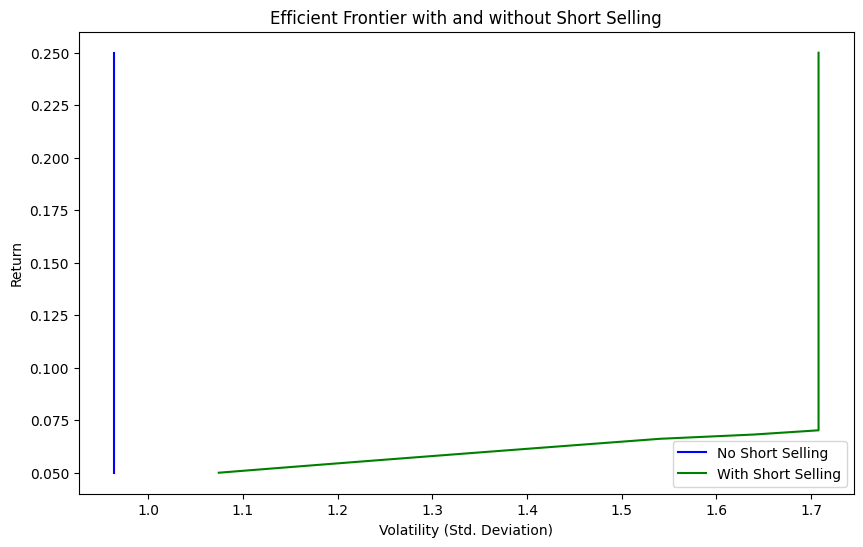

In [2]:

# Generate some random data for the assets
np.random.seed(42)
num_assets = 4
returns = np.random.randn(1000, num_assets)
mean_returns = np.mean(returns, axis=0)
cov_matrix = np.cov(returns, rowvar=False)

# Function to calculate portfolio performance (return and volatility)
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_volatility, portfolio_return

# Function to minimize (negative Sharpe ratio)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds_no_short = tuple((0, 1) for asset in range(num_assets))
bounds_with_short = tuple((-1, 1) for asset in range(num_assets))

# Efficient frontier without short selling
def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

def efficient_frontier(mean_returns, cov_matrix, bounds):
    frontier_returns = np.linspace(0.05, 0.25, 100)
    frontier_volatility = []

    for ret in frontier_returns:
        constraints = (
            {'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[1] - ret},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        )
        result = minimize(minimize_volatility, num_assets * [1. / num_assets,], args=(mean_returns, cov_matrix),
                          method='SLSQP', bounds=bounds, constraints=constraints)
        frontier_volatility.append(result['fun'])

    return frontier_volatility, frontier_returns

# Calculate efficient frontiers
vol_no_short, ret_no_short = efficient_frontier(mean_returns, cov_matrix, bounds_no_short)
vol_with_short, ret_with_short = efficient_frontier(mean_returns, cov_matrix, bounds_with_short)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(vol_no_short, ret_no_short, label='No Short Selling', color='blue')
plt.plot(vol_with_short, ret_with_short, label='With Short Selling', color='green')
plt.title('Efficient Frontier with and without Short Selling')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Return')
plt.legend()
plt.show()

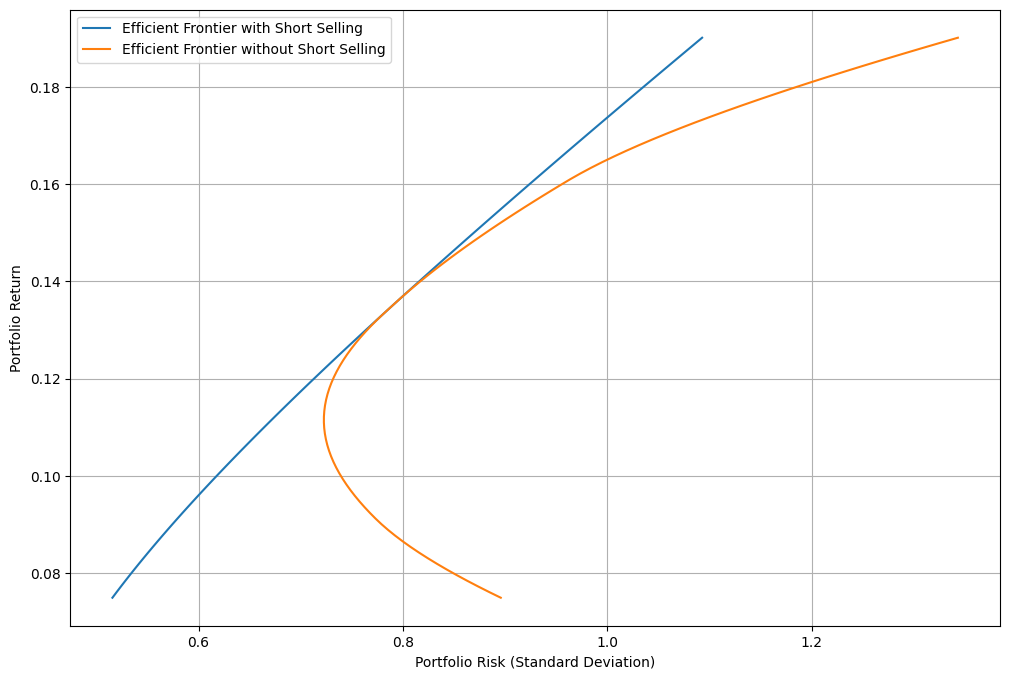

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Define the expected returns and covariance matrix for a set of assets
np.random.seed(42)
num_assets = 4
returns = np.random.rand(num_assets) * 0.2  # Expected returns between 0 and 0.2
cov_matrix = np.random.rand(num_assets, num_assets)
cov_matrix = np.dot(cov_matrix, cov_matrix.T)  # To make it positive semi-definite

# Generate a range of target returns
target_returns = np.linspace(min(returns), max(returns), 100)

# Lists to store portfolio risks and returns
risks_with_short = []
returns_with_short = []
risks_no_short = []
returns_no_short = []

# Loop over target returns to compute efficient frontiers
for target_return in target_returns:
    # With short selling allowed
    weights = cp.Variable(num_assets)
    portfolio_return = returns @ weights
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    problem = cp.Problem(cp.Minimize(portfolio_variance),
                         [cp.sum(weights) == 1,
                          portfolio_return == target_return])
    problem.solve()
    if problem.status == cp.OPTIMAL:
        risks_with_short.append(np.sqrt(portfolio_variance.value))
        returns_with_short.append(target_return)
    
    # No short selling allowed
    weights = cp.Variable(num_assets)
    portfolio_return = returns @ weights
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    problem = cp.Problem(cp.Minimize(portfolio_variance),
                         [cp.sum(weights) == 1,
                          portfolio_return == target_return,
                          weights >= 0])
    problem.solve()
    if problem.status == cp.OPTIMAL:
        risks_no_short.append(np.sqrt(portfolio_variance.value))
        returns_no_short.append(target_return)

# Plotting the efficient frontiers
plt.figure(figsize=(12, 8))
plt.plot(risks_with_short, returns_with_short, label='Efficient Frontier with Short Selling')
plt.plot(risks_no_short, returns_no_short, label='Efficient Frontier without Short Selling')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True)
plt.show()


## New graph

In [10]:
market_spread_over_sp = pd.read_csv('../../Pairs_SP500_FPT/1mo_rolling_hist_stock_minus_sp_vol.csv', index_col=0, parse_dates=True)
market_spread_over_sp
market_spread_over_sp

,AAPL_US,AAP_US,ABC_US,ABT_US,ACGL_US,ACN_US,ADBE_US,ADI_US,ADM_US,ADP_US,...,WTW_US,WYNN_US,WY_US,XEL_US,XOM_US,XRAY_US,YUM_US,ZBH_US,ZBRA_US,ZION_US
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-23,0.039322,0.220554,0.073998,0.191724,-0.029673,0.564146,0.470344,0.503317,-0.003453,0.202416,...,0.163120,0.134027,0.086240,0.401262,0.076908,-0.000055,0.089455,0.049784,0.067132,-0.000160
2003-01-24,0.016141,0.175995,0.035204,0.156038,-0.073877,0.516507,0.443201,0.470435,-0.027308,0.160957,...,0.136255,0.104739,0.106110,0.360691,0.045606,0.001039,0.024479,0.006825,0.017143,-0.042731
2003-01-27,0.096772,0.077694,0.061369,0.190281,-0.043017,0.540740,0.423997,0.402952,0.012363,0.194239,...,0.161819,0.139103,0.130708,0.317565,0.048439,0.036944,0.089923,0.056292,0.082348,0.006434
2003-01-28,0.127973,0.090000,0.064567,0.123950,-0.055548,0.521598,0.395934,0.392890,-0.020546,0.206377,...,0.139738,0.116845,0.109946,0.284534,0.049267,-0.027233,0.061764,0.083019,0.068854,0.013404
2003-01-29,0.131769,0.089362,0.015336,0.098325,-0.074437,0.519862,0.336483,0.383433,-0.022804,0.206784,...,0.136490,0.104471,0.095703,0.086507,0.124024,-0.025613,0.083451,0.142257,0.019962,0.009339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-26,0.022596,0.300713,-0.002193,0.029348,0.222055,0.126439,0.433879,0.418505,0.177302,0.073040,...,0.081152,0.420462,0.062608,-0.012080,0.133187,0.092411,0.073130,0.079504,0.295521,0.783884
2023-05-30,0.022156,0.296161,0.021757,0.036989,0.208283,0.110676,0.427080,0.417936,0.198012,0.085449,...,0.083832,0.423767,0.075195,-0.008823,0.140979,0.097066,0.077561,0.085713,0.278510,0.815702
2023-05-31,0.010676,1.879097,0.068046,0.030410,0.204893,0.121724,0.424349,0.409683,0.196012,0.077270,...,0.084396,0.417881,0.068482,0.033693,0.143535,0.083292,0.081229,0.075066,0.285183,0.867142


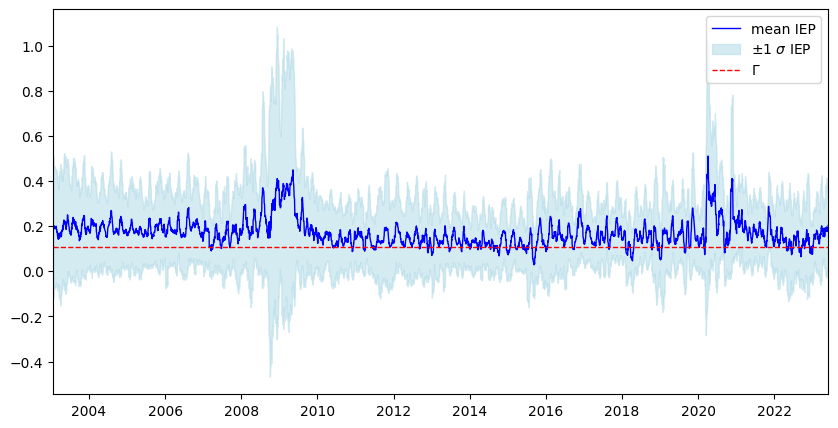

In [18]:
s_mean = market_spread_over_sp.mean(axis=1)
s_std = market_spread_over_sp.std(axis=1)
plt.figure(figsize=(10, 5))
plt.plot(s_mean, label='mean IEP', color='blue',linewidth=1)
plt.plot()

# Plot shaded region for ±1 standard deviation
plt.fill_between(
    s_mean.index, 
    s_mean - s_std, 
    s_mean + s_std, 
    color='lightblue', alpha=0.5, label=r'±1 $\sigma$ IEP'
)

plt.axhline(y=.1085, color='red', linestyle='--', linewidth=1, label=r'$\Gamma$')
# plt.xlabel('Date')
# plt.ylabel('Value')

plt.xlim(s_mean.index.min(), s_mean.index.max())
# plt.title('±1 standard deviation IEP')
plt.legend()
plt.show()

## MSCI

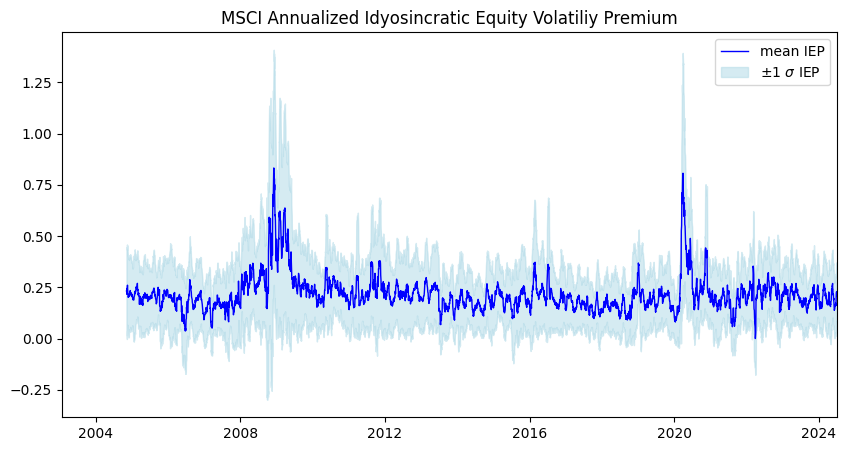

In [2]:
market_spread_over_sp = pd.read_csv('../../1mo_rolling_hist_stock_minus_msci_vol.csv', index_col=0, parse_dates=True)

s_mean = market_spread_over_sp.mean(axis=1)
s_std = market_spread_over_sp.std(axis=1)
plt.figure(figsize=(10, 5))
plt.plot(s_mean, label='mean IEP', color='blue',linewidth=1)
plt.plot()

# Plot shaded region for ±1 standard deviation
plt.fill_between(
    s_mean.index, 
    s_mean - s_std, 
    s_mean + s_std, 
    color='lightblue', alpha=0.5, label=r'±1 $\sigma$ IEP'
)

# plt.xlabel('Date')
# plt.ylabel('Value')

plt.xlim(s_mean.index.min(), s_mean.index.max())
plt.title('MSCI Annualized Idyosincratic Equity Volatiliy Premium')
plt.legend()
plt.show()